# 2024 NBA Future Analytics Stars Coding Exercise

### Neural Network Using TensorFlow

#### Tomas Kersulis

In [1]:
# import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense

In [2]:
# Get data from csv file
df = pd.read_csv('fas_2024.csv',sep=',')
player_stats = df.values[:,2:] # Stats for all players for months of October and November
real_three_pct = df.values[:,1] # Season long 3 pt percentage

In [13]:
# Create neural network
class NeuralNetwork:
    """
    A neural network created to assist in predicting NBA player statistics.
    Citation for help: https://www.tensorflow.org/guide/keras/sequential_model
    """
    def __init__(self, input_dimension, width_list):
        """
        Initialize a NeuralNetwork with a specified input dimension and width_list to
        define the number of hidden layers and how wide each of these layers are in
        the NeuralNetwork.
        
        Attributes:
            input_dimension     The number of inputs into the first layer of the NeuralNetwork
            width_list          An int list of the the width (number of nodes in a layer) of
                                of each hidden layer of the NeuralNetwork, excluding the input
                                and output layer (i.e. for a NeuralNetwork with one hidden
                                layer of width 50, width_list is [50])
        """
        self.model = Sequential()
        self.model.add(Dense(width_list[0], input_dim=input_dimension,
            activation='relu'))
        for layer in width_list[1:]:
            self.model.add(Dense(layer, activation='relu'))
        self.model.add(Dense(1, activation='linear'))
        self.model.compile(loss='mean_squared_error', optimizer='adam')
        
    def run(self, epochs, batch_size, training_x, training_y, testing_x, testing_y):
        """
        Train and test the NeuralNetwork using the specified number of epochs and batch size.
        
        Attributes:
            epochs           Number of epochs to train the NeuralNetwork for
            batch size       Size of the batch of training data points used
            training_x       training input data
            training_y       training real output data
            testing_x        testing input data
            testing_y        testing real output data
        """
        # Fit the neural network
        self.model.fit(training_x, training_y, epochs=epochs, batch_size=batch_size, verbose=0)

        # Get predictions for validation data
        predicted_y = self.model.predict(testing_x)

        # Calculate the mean squared error
        mse = mean_squared_error(testing_y, predicted_y)
        
        return mse, predicted_y

In [14]:
# randomly split the data into a 60/20/20 training/validation/test split
def data_split(player_stats, real_three_pct):
    """
    Randomly split the data given into a 60/20/20 training/validation/test split.
    
    Attributes:
        player_stats        Two-dimensional array for the input data player stats
                            for the months of October and November where the rows
                            are each player's stats and the columns are the stat
                            for each player
        real_three_pct      One-dimensional array for player's season long three
                            point percentage
    """
    n_players = len(player_stats)
    player_indexes = np.arange(n_players)
    
    # Randomly assign the players to the training group
    training_indexes = np.random.choice(player_indexes, int(n_players * 0.6), replace=False)
    training_x = player_stats[training_indexes]
    training_y = real_three_pct[training_indexes]
    
    # Randomly assign the players to the validation group
    non_training_players = n_players - len(training_indexes)
    validation_indexes = np.ones(n_players) / non_training_players
    validation_indexes[training_indexes] = 0
    validation_indexes = np.random.choice(player_indexes, int(non_training_players / 2), \
                                          p=validation_indexes, replace=False)
    validation_x = player_stats[validation_indexes]
    validation_y = real_three_pct[validation_indexes]
    
    # Randomly assign the players to the testing group
    testing_indexes = np.ones(n_players, bool)
    testing_indexes[training_indexes] = False
    testing_indexes[validation_indexes] = False
    testing_indexes = player_indexes[testing_indexes]
    testing_x = player_stats[testing_indexes]
    testing_y = real_three_pct[testing_indexes]
    
    # return the resulting split
    # x: model input data, y: real output data
    # Citation help: https://stackoverflow.com/questions/58636087/tensorflow-valueerror-failed-to-convert-a-numpy-array-to-a-tensor-unsupporte
    return np.asarray(training_x).astype(np.float32), \
            np.asarray(training_y).astype(np.float32), \
            np.asarray(validation_x).astype(np.float32), \
            np.asarray(validation_y).astype(np.float32), \
            np.asarray(testing_x).astype(np.float32), \
            np.asarray(testing_y).astype(np.float32)

In [20]:
def validation(training_x, training_y, validation_x, validation_y):
    """
    Perform validation on the testing split to find the best hyperparameters for the
    neural network: the depth and width of the hidden layers.
    
    Attributes:
        training_x       training input data
        training_y       training real output data
        validation_x     validation input data
        validation_y     validation real output data
    """
    num_input_features = len(training_x[0])
    best_mse = float('inf')
    mse_dict = {}
    print("Training and validating hyperparameters...")
    for depth in range(1, 4):
        for width in range(10, 110, 10):
            # Create, train, and test the neural network with the hyperparameters
            neural_network = NeuralNetwork(num_input_features, [width] * depth)
            mse, _ = neural_network.run(1000, 10, training_x, training_y, validation_x, validation_y)

            print("Depth: " + str(depth) + ", Width: " + str(width) + ", MSE: " + str(mse))
            mse_dict[(depth, width)] = mse
            if mse < best_mse:
                best_mse = mse
                best_hyperparameters = (depth, width)
    
    # Return the best hyperparameters
    return best_hyperparameters, mse_dict

In [55]:
def testing(training_x, training_y, testing_x, testing_y, depth, width):
    """
    Test the neural network to find the mean squared error of the model using
    the best hyperparameters found during validation for the depth and width
    of the hidden layers of the neural network.
    
    Attributes:
        training_x       training input data
        training_y       training real output data
        testing_x        testing input data
        testing_y        testing real output data
        depth            number of hidden layers in neural network
        width            number of nodes in each hidden layer
    """
    num_input_features = len(training_x[0])
    
    # Test the neural network with the hyperparameters
    neural_network = NeuralNetwork(num_input_features, [width] * depth)
    mse, predicted_y = neural_network.run(1000, 10, training_x, training_y, testing_x, testing_y)
    
    # Plot the squared error for the test group
    testing_indexes = np.arange(len(testing_y))
    plt.scatter(testing_indexes, np.square(predicted_y.T - testing_y), label="individual players' SE")
    # Citation help: https://stackoverflow.com/questions/33382619/plot-a-horizontal-line-on-a-given-plot
    plt.axhline(y=mse, color='r', linestyle='-', label="MSE")
    plt.title("Squared Error of Test Group")
    plt.ylabel("Squared Error")
    plt.axhline(y=0, color='black', linestyle='-')
    plt.legend()
    
    return mse

In [24]:
# Validate the model
training_x, training_y, validation_x, validation_y, testing_x, testing_y = data_split(player_stats, real_three_pct)
(depth, width), mse_dict = validation(training_x, training_y, validation_x, validation_y)

print("Best hyperparameters", (depth, width))

Training and validating hyperparameters...
Depth: 1, Width: 10, MSE: 0.120870136
Depth: 1, Width: 20, MSE: 0.15386361
Depth: 1, Width: 30, MSE: 0.36834958
Depth: 1, Width: 40, MSE: 0.49117386
Depth: 1, Width: 50, MSE: 0.44563577
Depth: 1, Width: 60, MSE: 0.16660224
Depth: 1, Width: 70, MSE: 0.37503898
Depth: 1, Width: 80, MSE: 0.14010264
Depth: 1, Width: 90, MSE: 0.33866084
Depth: 1, Width: 100, MSE: 0.58148134
Depth: 2, Width: 10, MSE: 0.0028427138
Depth: 2, Width: 20, MSE: 0.16543767
Depth: 2, Width: 30, MSE: 0.007828518
Depth: 2, Width: 40, MSE: 0.17936519
Depth: 2, Width: 50, MSE: 0.012781421
Depth: 2, Width: 60, MSE: 0.02418672
Depth: 2, Width: 70, MSE: 0.024716971
Depth: 2, Width: 80, MSE: 0.03517339
Depth: 2, Width: 90, MSE: 0.024852885
Depth: 2, Width: 100, MSE: 0.015748354
Depth: 3, Width: 10, MSE: 0.0014693972
Depth: 3, Width: 20, MSE: 0.24356681
Depth: 3, Width: 30, MSE: 0.033171594
Depth: 3, Width: 40, MSE: 0.021695457
Depth: 3, Width: 50, MSE: 0.03310942
Depth: 3, Width: 6

Mean Squared Error of Model: 0.0048557403


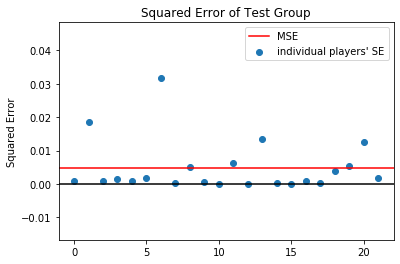

In [63]:
# Test the model
mse = testing(training_x, training_y, testing_x, testing_y, depth, width)
print("Mean Squared Error of Model:", mse)